In [1]:
import sys
sys.path.append('../..')
from semantic_odes.api import SemanticODE, BSplineBasisFunctions, PolynomialBasisFunctions, create_full_composition_library, CompositionMap
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from semantic_odes.model_numpy import calculate_loss
from semantic_odes.datasets import get_pk_dataset, get_pk_dataset_extrapolation
from experiments.benchmark import run_benchmark, SemanticODEBenchmark, SINDyBenchmark, WeakSINDyBenchmark, generate_indices


def mean_rmse(y_true_list, y_pred_list):
    rmse_scores = [np.sqrt(np.mean((y_true_i - y_pred_i)**2)) for y_true_i, y_pred_i in zip(y_true_list, y_pred_list)]
    return np.mean(rmse_scores)

In [2]:
global_seed = 2

n_samples = 100
n_measurements = 20
noise_std = 0.01

pk_dataset = get_pk_dataset(n_samples=n_samples, n_measurements=n_measurements, noise_std=noise_std, seed=global_seed)
pk_dataset_extrapolation = get_pk_dataset_extrapolation(n_samples=n_samples, n_measurements=n_measurements*2, noise_std=noise_std, seed=global_seed)

In [3]:
composition_library = create_full_composition_library(max_length=4,is_infinite=True)

# filter through the composition library to remove compositions that do not end with -+h
composition_library = [c for c in composition_library if c[-1] == '-+h']

In [4]:
composition_library

[['+-c', '--c', '-+h'],
 ['--c', '-+h'],
 ['--c', '-+c', '--c', '-+h'],
 ['-+h'],
 ['-+c', '--c', '-+h'],
 ['++c', '+-c', '--c', '-+h']]

In [5]:
opt_config = {
    'lr': 0.1,
    'n_epochs': 200,
    'batch_size': 256,
    'weight_decay': 0.0,
    'device': 'cpu',
    'dis_loss_coeff_1': 1e-2,
    'dis_loss_coeff_2': 1e-6,
    'n_tune':20
    # 'n_tune':0
}

config = {
    't_range': (0, 1),
    'basis_function_type': 'bspline',
    'num_basis_functions': 6,
    'max_branches': 3,
    'composition_library': composition_library,
    'opt_config': opt_config,
    'verbose': True,
    'subtype': 'default'
    }

basis_functions = BSplineBasisFunctions(n_basis=6,k=3, include_bias=True, include_linear=True)

# semantic_ode = SemanticODE((0,None),basis_functions,composition_library,max_branches=3,seed=global_seed,opt_config=opt_config,verbose=True)

semantic_ode_benchmark = SemanticODEBenchmark(config)

train_indices, val_indices, test_indices = generate_indices(n_samples, 0.7, 0.15, seed=global_seed)

In [6]:
semantic_ode_benchmark.prepare_data(pk_dataset, train_indices, val_indices, test_indices)

In [7]:
semantic_ode =  SemanticODE((0,1),basis_functions,composition_library,max_branches=3,seed=global_seed,opt_config=opt_config,verbose=True)

{'device': 'cpu', 'n_epochs': 200, 'batch_size': 256, 'lr': 0.1, 'weight_decay': 0.0, 'fit_single': True, 'dis_loss_coeff_1': 0.01, 'dis_loss_coeff_2': 1e-06, 'n_tune': 20}


In [ ]:
# composition_map = CompositionMap([((-np.inf,np.inf),('+-c', '--c', '-+h'))])
# # composition_library = [['++c', '+-c', '--c', '-+h']]
# semantic_ode.composition_map = composition_map

# semantic_ode, results = semantic_ode_benchmark.train(semantic_ode)


semantic_ode, results = semantic_ode_benchmark.train(semantic_ode)

In [9]:
semantic_ode_benchmark.prepare_data(pk_dataset, train_indices, val_indices, test_indices)
_, results = semantic_ode_benchmark.evaluate(semantic_ode)
print(f"Test loss: {results['test_loss']:.4f}, std: {results['test_loss_std']:.4f}")

Smoothing did not converge for all seeds and methods
Best error: 0.011264920132298961
Best derivative error: 7.105427357601002e-15
Composition: ('+-c', '--c', '-+h')
Coordinates:
[[0.         0.35353535]
 [0.08853051 0.9275735 ]
 [0.12658624 0.83731318]]
Derivative at start: 11.163758277893066
Derivative at end: -3.55767822265625
Properties of infinite motif:
[0.04907513 0.30174452]
Second derivative at end: 0.0
Smoothing did not converge for all seeds and methods
Best error: 0.00803626596135576
Best derivative error: 7.105427357601002e-15
Composition: ('+-c', '--c', '-+h')
Coordinates:
[[0.         0.07070707]
 [0.09307466 0.71803361]
 [0.13039634 0.63837451]]
Derivative at start: 12.882587432861328
Derivative at end: -3.2015914916992188
Properties of infinite motif:
[0.05056673 0.27761403]
Second derivative at end: 0.0
Smoothing did not converge for all seeds and methods
Best error: 0.009808008443411564
Best derivative error: 7.105427357601002e-15
Composition: ('+-c', '--c', '-+h')
C

In [10]:
semantic_ode_benchmark.prepare_data(pk_dataset_extrapolation, train_indices, val_indices, test_indices)
_, results = semantic_ode_benchmark.evaluate(semantic_ode)
print(f"Test loss: {results['test_loss']:.4f}, std: {results['test_loss_std']:.4f}")

Smoothing did not converge for all seeds and methods
Best error: 0.011264920132298961
Best derivative error: 7.105427357601002e-15
Composition: ('+-c', '--c', '-+h')
Coordinates:
[[0.         0.35353535]
 [0.08853051 0.9275735 ]
 [0.12658624 0.83731318]]
Derivative at start: 11.163758277893066
Derivative at end: -3.55767822265625
Properties of infinite motif:
[0.04907513 0.30174452]
Second derivative at end: 0.0
Smoothing did not converge for all seeds and methods
Best error: 0.00803626596135576
Best derivative error: 7.105427357601002e-15
Composition: ('+-c', '--c', '-+h')
Coordinates:
[[0.         0.07070707]
 [0.09307466 0.71803361]
 [0.13039634 0.63837451]]
Derivative at start: 12.882587432861328
Derivative at end: -3.2015914916992188
Properties of infinite motif:
[0.05056673 0.27761403]
Second derivative at end: 0.0
Smoothing did not converge for all seeds and methods
Best error: 0.009808008443411564
Best derivative error: 7.105427357601002e-15
Composition: ('+-c', '--c', '-+h')
C

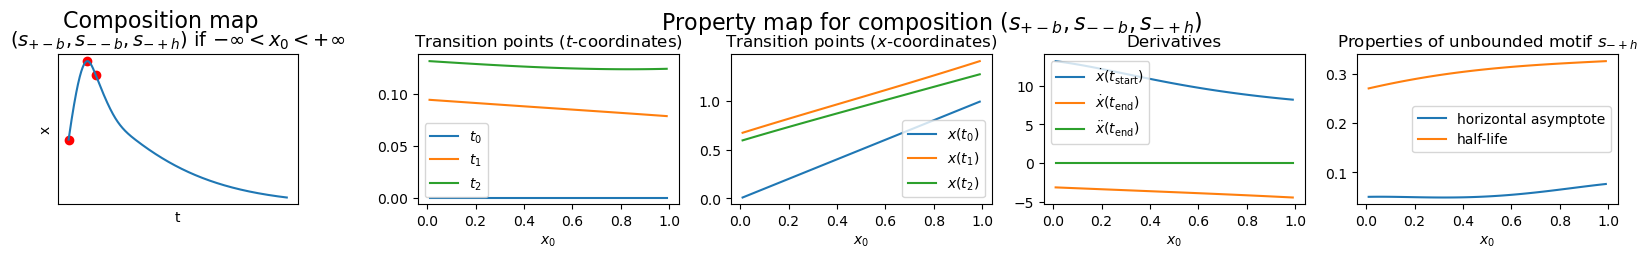

In [ ]:
semantic_ode.semantic_predictor.visualize_thin((0,1), property_map_figsize=(15,2.5),composition_map_figsize=(3,2.5))
# plt.tight_layout()
# add space on the lft of the figure
plt.subplots_adjust(bottom=0.2)
plt.savefig("output/Pharma Semantic ODE (Fig 7).pdf")

In [12]:
# semantic_ode.semantic_predictor.visualize((0,1), property_map_figsize=(20,3),composition_map_figsize=(20,2))
# plt.savefig("pk_model_semantic_1.pdf")

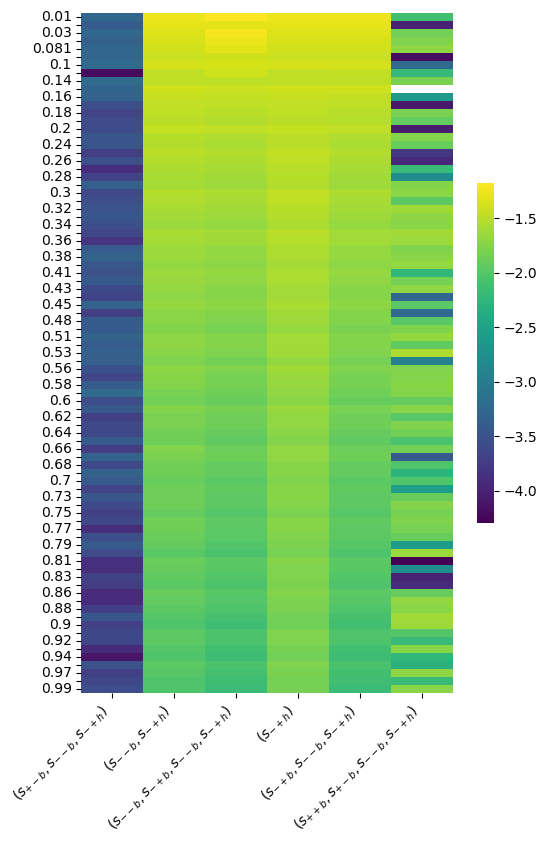

In [ ]:
fig, ax = plt.subplots(figsize=(6, 10), dpi=100)

semantic_ode.visualize_composition_scores_df(ax)
plt.subplots_adjust(bottom=0.2)
plt.savefig("output/Composition scores (Fig 10).pdf")

In [24]:
import torch

def new_torch_function(X,x0,y0,y1,y2):
    return torch.max(y0,torch.ones_like(y0)*1e-3).flatten()
semantic_ode.set_infinite_property_function_through_torch_model(0,0,new_torch_function)

In [25]:
semantic_ode_benchmark.prepare_data(pk_dataset, train_indices, val_indices, test_indices)
train_xs, train_ts, train_ys = semantic_ode_benchmark.X_train_val, semantic_ode_benchmark.T_train_val, semantic_ode_benchmark.Y_train_val
semantic_ode.refit_property_map(0,train_xs , train_ts, train_ys)

Refitting the property map to the data
Tuning the hyperparameters for the composition: ('+-c', '--c', '-+h')


[I 2024-10-02 05:26:57,646] A new study created in memory with name: no-name-1b7aff58-1dd8-4088-a608-c4c1901f5a7e
Seed set to 2


Fitting the model to the data using the composition: ('+-c', '--c', '-+h')
Finished after 52 epochs
Validation loss for ('+-c', '--c', '-+h'): 0.00026461848756298423


[I 2024-10-02 05:27:02,120] Trial 0 finished with value: 0.00026461848756298423 and parameters: {'dis_loss_coeff_2': 3.075807964310838e-06, 'lr': 0.00012697111322756423}. Best is trial 0 with value: 0.00026461848756298423.
Seed set to 2


Fitting the model to the data using the composition: ('+-c', '--c', '-+h')
Finished after 58 epochs
Validation loss for ('+-c', '--c', '-+h'): 0.00024014686641748995


[I 2024-10-02 05:27:08,437] Trial 1 finished with value: 0.00024014686641748995 and parameters: {'dis_loss_coeff_2': 2.4963175100206102e-05, 'lr': 0.005511750757691415}. Best is trial 1 with value: 0.00024014686641748995.
Seed set to 2


Fitting the model to the data using the composition: ('+-c', '--c', '-+h')
Finished after 56 epochs
Validation loss for ('+-c', '--c', '-+h'): 0.00022631286992691457


[I 2024-10-02 05:27:14,578] Trial 2 finished with value: 0.00022631286992691457 and parameters: {'dis_loss_coeff_2': 2.306441356351671e-06, 'lr': 0.002095749079193946}. Best is trial 2 with value: 0.00022631286992691457.
Seed set to 2


Fitting the model to the data using the composition: ('+-c', '--c', '-+h')
Finished after 52 epochs
Validation loss for ('+-c', '--c', '-+h'): 0.00022253033239394426


[I 2024-10-02 05:27:20,506] Trial 3 finished with value: 0.00022253033239394426 and parameters: {'dis_loss_coeff_2': 4.336996506330036e-08, 'lr': 0.029997417348655162}. Best is trial 3 with value: 0.00022253033239394426.
Seed set to 2


Fitting the model to the data using the composition: ('+-c', '--c', '-+h')
Finished after 64 epochs
Validation loss for ('+-c', '--c', '-+h'): 0.0002221604809165001


[I 2024-10-02 05:27:26,991] Trial 4 finished with value: 0.0002221604809165001 and parameters: {'dis_loss_coeff_2': 2.495958668320289e-07, 'lr': 0.0011676403660687692}. Best is trial 4 with value: 0.0002221604809165001.
Seed set to 2


Fitting the model to the data using the composition: ('+-c', '--c', '-+h')
Finished after 46 epochs
Validation loss for ('+-c', '--c', '-+h'): 0.00037661995156668127


[I 2024-10-02 05:27:32,206] Trial 5 finished with value: 0.00037661995156668127 and parameters: {'dis_loss_coeff_2': 9.312593842803703e-05, 'lr': 0.01307881440940144}. Best is trial 4 with value: 0.0002221604809165001.
Seed set to 2


Fitting the model to the data using the composition: ('+-c', '--c', '-+h')
Finished after 52 epochs
Validation loss for ('+-c', '--c', '-+h'): 0.0002222496987087652


[I 2024-10-02 05:27:37,330] Trial 6 finished with value: 0.0002222496987087652 and parameters: {'dis_loss_coeff_2': 1.1929975801543667e-08, 'lr': 0.01133215445049292}. Best is trial 4 with value: 0.0002221604809165001.
Seed set to 2


Fitting the model to the data using the composition: ('+-c', '--c', '-+h')
Finished after 54 epochs
Validation loss for ('+-c', '--c', '-+h'): 0.0002223250485258177


[I 2024-10-02 05:27:40,923] Trial 7 finished with value: 0.0002223250485258177 and parameters: {'dis_loss_coeff_2': 2.988951893159802e-08, 'lr': 0.13846518531662885}. Best is trial 4 with value: 0.0002221604809165001.
Seed set to 2


Fitting the model to the data using the composition: ('+-c', '--c', '-+h')
Finished after 48 epochs
Validation loss for ('+-c', '--c', '-+h'): 0.005820749793201685


[I 2024-10-02 05:27:45,637] Trial 8 finished with value: 0.005820749793201685 and parameters: {'dis_loss_coeff_2': 0.0067889457944746556, 'lr': 0.009483034914203468}. Best is trial 4 with value: 0.0002221604809165001.
Seed set to 2


Fitting the model to the data using the composition: ('+-c', '--c', '-+h')
Finished after 52 epochs
Validation loss for ('+-c', '--c', '-+h'): 0.0052500516176223755


[I 2024-10-02 05:27:51,568] Trial 9 finished with value: 0.0052500516176223755 and parameters: {'dis_loss_coeff_2': 0.005922320177157397, 'lr': 0.00020824851253449603}. Best is trial 4 with value: 0.0002221604809165001.
Seed set to 2


Fitting the model to the data using the composition: ('+-c', '--c', '-+h')
Finished after 54 epochs
Validation loss for ('+-c', '--c', '-+h'): 0.0002266435622004792


[I 2024-10-02 05:27:56,971] Trial 10 finished with value: 0.0002266435622004792 and parameters: {'dis_loss_coeff_2': 3.6938463171039087e-07, 'lr': 0.0008207461829173125}. Best is trial 4 with value: 0.0002221604809165001.
Seed set to 2


Fitting the model to the data using the composition: ('+-c', '--c', '-+h')
Finished after 50 epochs
Validation loss for ('+-c', '--c', '-+h'): 0.0002231306571047753


[I 2024-10-02 05:28:00,964] Trial 11 finished with value: 0.0002231306571047753 and parameters: {'dis_loss_coeff_2': 1.2272754988662722e-09, 'lr': 0.10175952223127224}. Best is trial 4 with value: 0.0002221604809165001.
Seed set to 2


Fitting the model to the data using the composition: ('+-c', '--c', '-+h')
Finished after 46 epochs
Validation loss for ('+-c', '--c', '-+h'): 0.00022256874945014715


[I 2024-10-02 05:28:02,554] Trial 12 finished with value: 0.00022256874945014715 and parameters: {'dis_loss_coeff_2': 1.4868012595724565e-09, 'lr': 0.8422254643281838}. Best is trial 4 with value: 0.0002221604809165001.
Seed set to 2


Fitting the model to the data using the composition: ('+-c', '--c', '-+h')
Finished after 62 epochs
Validation loss for ('+-c', '--c', '-+h'): 0.00022664637072011828


[I 2024-10-02 05:28:08,785] Trial 13 finished with value: 0.00022664637072011828 and parameters: {'dis_loss_coeff_2': 4.8393228856879356e-08, 'lr': 0.0007668669573578977}. Best is trial 4 with value: 0.0002221604809165001.
Seed set to 2


Fitting the model to the data using the composition: ('+-c', '--c', '-+h')
Finished after 94 epochs
Validation loss for ('+-c', '--c', '-+h'): 0.0002225008502136916


[I 2024-10-02 05:28:16,915] Trial 14 finished with value: 0.0002225008502136916 and parameters: {'dis_loss_coeff_2': 4.072395664915295e-07, 'lr': 0.0025143405198973347}. Best is trial 4 with value: 0.0002221604809165001.
Seed set to 2


Fitting the model to the data using the composition: ('+-c', '--c', '-+h')
Finished after 54 epochs
Validation loss for ('+-c', '--c', '-+h'): 0.00022269262990448624


[I 2024-10-02 05:28:22,336] Trial 15 finished with value: 0.00022269262990448624 and parameters: {'dis_loss_coeff_2': 7.814519252938593e-09, 'lr': 0.047379851141435336}. Best is trial 4 with value: 0.0002221604809165001.
Seed set to 2


Fitting the model to the data using the composition: ('+-c', '--c', '-+h')
Finished after 60 epochs
Validation loss for ('+-c', '--c', '-+h'): 0.0012303836410865188


[I 2024-10-02 05:28:29,078] Trial 16 finished with value: 0.0012303836410865188 and parameters: {'dis_loss_coeff_2': 0.00057656525505916, 'lr': 0.0005556817172638661}. Best is trial 4 with value: 0.0002221604809165001.
Seed set to 2


Fitting the model to the data using the composition: ('+-c', '--c', '-+h')
Finished after 64 epochs
Validation loss for ('+-c', '--c', '-+h'): 0.00022303521109279245


[I 2024-10-02 05:28:37,888] Trial 17 finished with value: 0.00022303521109279245 and parameters: {'dis_loss_coeff_2': 4.4412483097715577e-07, 'lr': 0.0015195919736881245}. Best is trial 4 with value: 0.0002221604809165001.
Seed set to 2


Fitting the model to the data using the composition: ('+-c', '--c', '-+h')
Finished after 126 epochs
Validation loss for ('+-c', '--c', '-+h'): 0.0002232184197055176


[I 2024-10-02 05:28:48,201] Trial 18 finished with value: 0.0002232184197055176 and parameters: {'dis_loss_coeff_2': 1.194397419559258e-08, 'lr': 0.006411397445468766}. Best is trial 4 with value: 0.0002221604809165001.
Seed set to 2


Fitting the model to the data using the composition: ('+-c', '--c', '-+h')
Finished after 90 epochs
Validation loss for ('+-c', '--c', '-+h'): 0.00023059533850755543


[I 2024-10-02 05:28:55,530] Trial 19 finished with value: 0.00023059533850755543 and parameters: {'dis_loss_coeff_2': 2.1807961834822326e-07, 'lr': 0.00034327588128230775}. Best is trial 4 with value: 0.0002221604809165001.


Best hyperparameters: {'dis_loss_coeff_2': 2.495958668320289e-07, 'lr': 0.0011676403660687692}


Seed set to 2


Fitting the model to the data using the composition: ('+-c', '--c', '-+h')


Seed set to 2


Finished after 125 epochs
Validation loss for ('+-c', '--c', '-+h'): 0.00022216065553948283
Property map refitted with validation loss: 0.00022216065553948283


'rm' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.

In [26]:
semantic_ode, results = semantic_ode_benchmark.evaluate(semantic_ode)
print(f"Test loss: {results['test_loss']:.4f}, std: {results['test_loss_std']:.4f}")

Smoothing did not converge for all seeds and methods
Best error: 0.012974306081424913
Best derivative error: 7.105427357601002e-15
Composition: ('+-c', '--c', '-+h')
Coordinates:
[[0.         0.44444445]
 [0.08767219 0.98552954]
 [0.1316188  0.88155758]]
Derivative at start: 11.405522346496582
Derivative at end: -3.548797607421875
Properties of infinite motif:
[0.         0.33420205]
Second derivative at end: 0.0
Smoothing did not converge for all seeds and methods
Best error: 0.01355920672962263
Best derivative error: 7.105427357601002e-15
Composition: ('+-c', '--c', '-+h')
Coordinates:
[[0.         0.54545456]
 [0.08602811 1.05997062]
 [0.13014466 0.95132709]]
Derivative at start: 10.703617095947266
Derivative at end: -3.6939620971679688
Properties of infinite motif:
[0.         0.33838475]
Second derivative at end: 0.0
Test loss: 0.0175, std: 0.0030


In [27]:
semantic_ode_benchmark.prepare_data(pk_dataset_extrapolation, train_indices, val_indices, test_indices)
_, results = semantic_ode_benchmark.evaluate(semantic_ode)
print(f"Test loss: {results['test_loss']:.4f}, std: {results['test_loss_std']:.4f}")

Smoothing did not converge for all seeds and methods
Best error: 0.012974306081424913
Best derivative error: 7.105427357601002e-15
Composition: ('+-c', '--c', '-+h')
Coordinates:
[[0.         0.44444445]
 [0.08767219 0.98552954]
 [0.1316188  0.88155758]]
Derivative at start: 11.405522346496582
Derivative at end: -3.548797607421875
Properties of infinite motif:
[0.         0.33420205]
Second derivative at end: 0.0
Smoothing did not converge for all seeds and methods
Best error: 0.01355920672962263
Best derivative error: 7.105427357601002e-15
Composition: ('+-c', '--c', '-+h')
Coordinates:
[[0.         0.54545456]
 [0.08602811 1.05997062]
 [0.13014466 0.95132709]]
Derivative at start: 10.703617095947266
Derivative at end: -3.6939620971679688
Properties of infinite motif:
[0.         0.33838475]
Second derivative at end: 0.0
Test loss: 0.0150, std: 0.0023


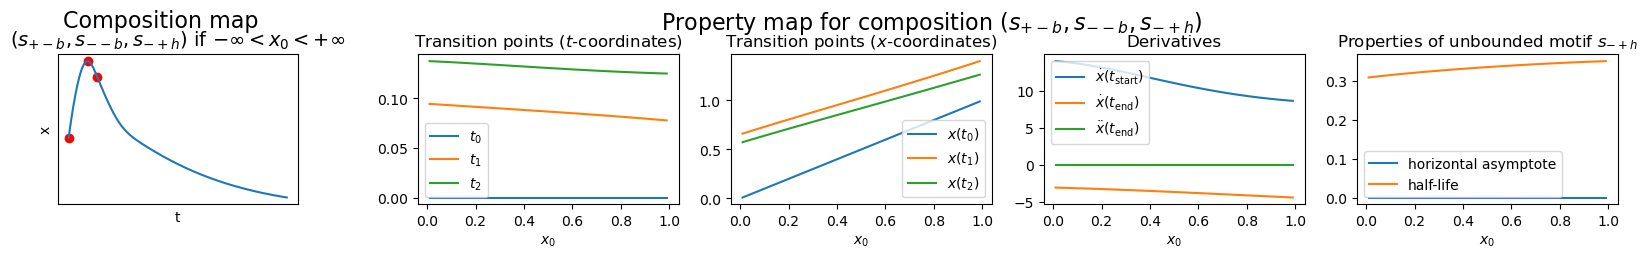

In [ ]:
semantic_ode.semantic_predictor.visualize_thin((0,1), property_map_figsize=(15,2.5),composition_map_figsize=(3,2.5))
plt.subplots_adjust(bottom=0.2)
plt.savefig("output/Pharma Semantic ODE Edited (Fig 8).pdf")